<a href="https://colab.research.google.com/github/ernanhughes/fine-tuning-llm/blob/main/Finetune_LLaMA_with_Alpaca_GPT_4_Data_(5K_Samples)_Flash_Attention_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ⚠ IMPORTANT ⚠

Please ensure your Colab runtime is set to the following:

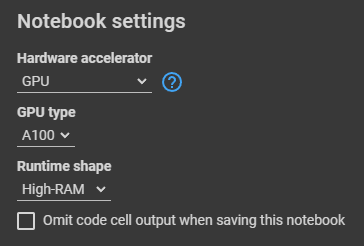


# Let's instruct-tune LLaMA-7B!

If you haven't already had the change to experience the newest LLaMA model, check out these resources:

- [Release Material](https://about.fb.com/news/2023/07/llama-2/)
- [Model Hosted on HF](https://huggingface.co/spaces/ysharma/Explore_llamav2_with_TGI)
- [HF Blog About the Release](https://huggingface.co/blog/llama2)

Today, we'll be working with the `7b-hf` version of the model. Put simply, this is a 7 billion parameter model saved in a HF friendly format.

You can find more information about the model [here](https://huggingface.co/NousResearch/Llama-2-7b-hf)

The astute among you will notice that this is not the official Meta model. In order to use the official weights, you can request access [here](https://ai.meta.com/resources/models-and-libraries/llama-downloads/), but for now we'll be leveraging accessible model weights.

### Technologies Used

In this notebook we'll be taking advantage of the follow technologies, it's a long list - I know.

- [Flash Attention](https://arxiv.org/abs/2205.14135)
- LoRA
  - [LoRA Paper](https://arxiv.org/abs/2106.09685)
  - [HF's `peft` library](https://github.com/huggingface/peft)
- HF's `transformers` library
- `torch`
- `cuda`
- 4-bit Quantization (and Double-Quantization) from Tim Dettmers.
  - [QLoRA Paper](https://arxiv.org/abs/2305.14314)
  - `bitsandbytes`
- `SFTTrainer`
  - [TRL Library](https://github.com/lvwerra/trl)
- HF's `datasets`
- HF's `huggingface_hub`

As you can see, we're relying on a number of amazing libraries, frameworks, and more.

It's absolutely incredible what is possible these days!

### Dependencies

First things first, let's grab some dependencies.

In [ ]:
!pip install -U -q "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1"

### Data

Now, we'll load some of the GPT-4 generated Alpaca-GPT dataset.

You can use essentially any data you'd like here - though I'd recommend leveraging some kind of instruction dataset.



In [ ]:
from datasets import load_dataset

alpaca_gpt_4_dataset = load_dataset("c-s-ale/alpaca-gpt4-data", split="train")

In [ ]:
len(alpaca_gpt_4_dataset)

52002

We're going to do some naive filtering and sampling in order to allow the notebook to run in a reasonable amount of time (~1hr.)

In [ ]:
dataset = alpaca_gpt_4_dataset.filter(lambda example: (len(example["input"]) + len(example["output"]) + len(example["instruction"])) <= 2000)

In [ ]:
len(dataset)

49406

In [ ]:
dataset = dataset.select(range(5_000))

In [ ]:
len(dataset)

5000

As always, we'll need to move our data into an instruction-prompt.

There are many different approaches to this specific step, and you should feel free to modify and experiment here!

In [ ]:
def format_row_as_instruction_prompt(example):
    primer_prompt_with_input = f"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request."
    primer_prompt_no_input = f"Below is an instruction that describes a task. Write a response that appropriately completes the request."
    instruction_template = f"Provided an instruction and a input, please provide a coherent response. \n### Instruction:\n{example['instruction']}"
    input_template = f"### Input:\n{example['input']}"
    response_template = f"### Response:\n{example['output']}"

    total_prompt_list = []

    if example["input"]:
        total_prompt_list.append(primer_prompt_with_input)
        total_prompt_list.append(input_template)
    else:
        total_prompt_list.append(primer_prompt_no_input)

    total_prompt_list.append(response_template)

    return "\n\n".join(total_prompt_list)

Let's just confirm the format is as we expect:

In [ ]:
print(format_row_as_instruction_prompt(alpaca_gpt_4_dataset[5]))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Input:
Twitter, Instagram, Telegram

### Response:
The odd one out is Telegram. Twitter and Instagram are social media platforms mainly for sharing information, images and videos while Telegram is a cloud-based instant messaging and voice-over-IP service.


We'll leverage a helpful utility from Phil Schmid's [repo](https://github.com/philschmid/deep-learning-pytorch-huggingface/blob/main/training/utils/llama_patch.py)

(taken from his helpful walkthrough [here](https://www.philschmid.de/instruction-tune-llama-2))

NOTE: It will take a decent amount of time to install Flash Attention - please be patient!

In [ ]:
!pip install -q ninja packaging

In [ ]:
!MAX_JOBS=4 pip install -U flash-attn --no-build-isolation

In [ ]:
!git clone https://github.com/philschmid/deep-learning-pytorch-huggingface.git

fatal: destination path 'deep-learning-pytorch-huggingface' already exists and is not an empty directory.


In [ ]:
%cd deep-learning-pytorch-huggingface/training/

/content/deep-learning-pytorch-huggingface/training


### Training Preparation

Now we're ready to start setting up our configuration options!

We're going to do the following preparation work:

1. If desired: Set-up FlashAttention through Phil's utility function.
2. Create our BitsAndBytesConfig for 4bit training.
3. Set up our LoRA config to leverage PEFT-LoRA

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

use_flash = True
use_flash_attention = None

if use_flash:
    if torch.cuda.get_device_capability()[0] >= 8:
        from utils.llama_patch import replace_attn_with_flash_attn
        print("Flashing That Attention")
        replace_attn_with_flash_attn()
        use_flash_attention = True

model_id = "NousResearch/Llama-2-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto"
)

model.config.pretraining_tp = 1

if use_flash_attention:
    from utils.llama_patch import forward
    assert model.model.layers[0].self_attn.forward.__doc__ == forward.__doc__, "Model didn't Flash Attention"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Flashing That Attention


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=32,
    bias="none",
    task_type="CAUSAL_LM"
)

model = prepare_model_for_kbit_training(model)

### Training

Now that we have all that out of the way, let's set up our `TrainingArguments`, since `SFTTRainer` extends the base HF `Trainer`, we can use familiar args. for this step!

You'll notice that the values for `per_device_train_batch_size` are very low - this is largely due to Colab constraints. You could leverage a dedicate cloud instance provider if you were seeking to do some more serious fine-tuning/instruct-tuning.

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="llama_7_nf4_alpaca_gpt4",
    num_train_epochs=3,
    per_device_train_batch_size=4 if use_flash_attention else 1,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=1,
    save_strategy="steps",
    save_steps=100,
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    fp16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=True
)

if use_flash_attention:
    from utils.llama_patch import upcast_layer_for_flash_attention
    torch_dtype = torch.bfloat16 if args.bf16 else torch.float16 if args.fp16 else torch.float32
    model = upcast_layer_for_flash_attention(model, torch_dtype)

model = get_peft_model(model, peft_config)

Now we can set up our `SFTTrainer`!

You'll notice that we provide the dataset - but we do not indicate labels/masks for our inputs - this is because behind the scenes, SFTTrainer is going to construct a new dataset for us (as well as efficiently packing that dataset).

You could certainly take a number of approaches here, but for now we'll stick to the basics!



In [ ]:
from trl import SFTTrainer

max_seq_len = 2048

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_len,
    tokenizer=tokenizer,
    packing=True,
    formatting_func=format_row_as_instruction_prompt,
    args=args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:246: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictonnary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


Nothing left to do but train!

In [ ]:
trainer.train()

Let's go ahead and save our model!

In [ ]:
trainer.save_model()

### Testing Our Model

Now that we've instruct-tuned our model - let's see how it performs!

In [ ]:
if use_flash_attention:
    from utils.llama_patch import unplace_flash_attn_with_attn
    unplace_flash_attn_with_attn()

import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

args.output_dir = "llama_7_nf4_alpaca_gpt4"

model = AutoPeftModelForCausalLM.from_pretrained(
    args.output_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)

tokenizer = AutoTokenizer.from_pretrained(args.output_dir)

In [ ]:
from random import randrange

sample = dataset[5]

In [ ]:
print(sample)

First, let's see how our model handles this instruction task!

In [ ]:
instruction_template = f"### Instruction:\n{sample['instruction']}"
input_template = f"### Input:\n{sample['input']}"
generate_response_template = "### Response:"
true_response_template = f"{sample['output']}"

partial_prompt_list = [instruction_template]

if sample["input"]:
    partial_prompt_list.append(input_template)

partial_prompt_list.append(generate_response_template)

generate_prompt = "\n\n".join(partial_prompt_list)

print(f"Prompt:\n{generate_prompt}\n --------")

input_ids = tokenizer(generate_prompt, return_tensors="pt", truncation=True).input_ids.cuda()

outputs = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9, temperature=0.9)

print(f"Generated Response:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(generate_prompt):]}\n -----")
print(f"Actual Response:\n{true_response_template}")

Not bad! It provides a decent explanation - and gets the answer "correct"!

Now let's see how the base model would've performed on the same prompt:

In [ ]:
model_id = "NousResearch/Llama-2-7b-hf"

base_llama_2 = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)

base_llama_2_tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
instruction_template = f"### Instruction:\n{sample['instruction']}"
input_template = f"### Input:\n{sample['input']}"
generate_response_template = "### Response:"
true_response_template = f"{sample['output']}"

partial_prompt_list = [instruction_template]

if sample["input"]:
    partial_prompt_list.append(input_template)

partial_prompt_list.append(generate_response_template)

generate_prompt = "\n\n".join(partial_prompt_list)

print(f"Prompt:\n{generate_prompt}\n --------")

input_ids = base_llama_2_tokenizer(generate_prompt, return_tensors="pt", truncation=True).input_ids.cuda()

outputs = base_llama_2.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9, temperature=0.9)

print(f"Generated Response:\n{base_llama_2_tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(generate_prompt):]}\n -----")
print(f"Actual Response:\n{true_response_template}")

Well, let's just say - not well!

Even with ~2 epochs of 5k samples, you can already see a massive improvement in the output of our model!

### Export and Share

Now that we've done the hard part - let's do the easy part and send this out into the world!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(
    args.output_dir,
    low_cpu_mem_usage=True
)

merged_model = model.merge_and_unload()

In [ ]:
HF_USERNAME = "ai-maker-space"
HF_REPO_NAME = "instruct-tuned-llama-7b-hf-alpaca_gpt4_5_000_samples"

merged_model.push_to_hub(f"{HF_USERNAME}/{HF_REPO_NAME}")
tokenizer.push_to_hub(f"{HF_USERNAME}/{HF_REPO_NAME}")